# Utility and Best Practices for Tools in Agents

## What is a "tool"?
A "tool" is a function or external service that the agent can call to accomplish a specific task (e.g., get weather, perform an internet search, convert currency, etc.). Tools allow the agent to extend its capabilities beyond simple text generation.

## How does it work?
- The agent receives a request from the user.
- It analyzes the request and decides if it needs to use a tool to respond.
- If yes, it calls the appropriate tool, retrieves the result, then uses it to formulate its final response.

## When to use a tool?
- When the response requires dynamic or external information (e.g., current time, weather, web search).
- To perform calculations, conversions, or access external databases/services.

## When is it not necessary?
- If the response can be generated solely from the agent's internal knowledge (e.g., theoretical explanations, definitions, simple logic).
- If the requested information is static or already known to the agent.

## Best practices and patterns
- **Clearly define the interface** of each tool (well-typed inputs/outputs).
- **Limit the number of tools** to those truly useful to avoid confusion.
- **Give explicit names** to tools to facilitate their selection by the agent.
- **Handle errors**: plan for cases where the tool fails or returns no result.
- **Document each tool** (description, usage examples).
- **Recommended pattern**:
    - Use tools for any external interaction or specialized tasks.
    - Prefer direct generation for simple or purely conversational responses.

## Rules to follow
- Do not use a tool if it is not necessary (avoid unnecessary calls).
- Always verify and validate a tool's output before using it in the response.
- Separate the agent's business logic from the tool implementation for better maintainability.


In [1]:
from typing import Literal
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.tools import tool
from langchain_ollama.chat_models import ChatOllama
import requests
from dotenv import load_dotenv
import json
from datetime import datetime, timedelta
import re
import hashlib
import base64
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langchain_tavily import TavilySearch

load_dotenv()


True

In [2]:
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def get_retry_session():
    session = requests.Session()
    retry = Retry(
        total=5,
        backoff_factor=1,
        status_forcelist=[433],
        allowed_methods=["HEAD", "GET", "OPTIONS", "POST"]
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session


In [3]:
@tool
def search_internet(query: str) -> str:
    """Searches for information on the internet via DuckDuckGo."""
    try:
        session = get_retry_session()
        url = f"https://api.duckduckgo.com/?q={query}&format=json"
        response = session.get(url, timeout=5)
        data = response.json()
        abstract = data.get("AbstractText", "No results found")
        return abstract if abstract else "No information available"
    except Exception as e:
        return f"Search error: {str(e)}"


@tool
def get_weather(city: str) -> str:
    """Retrieves the current weather for a given city."""
    try:
        session = get_retry_session()
        url = f"https://wttr.in/{city}?format=j1"
        response = session.get(url, timeout=5)
        data = response.json()
        current = data["current_condition"][0]
        weather_info = f"""Weather in {city}:
        - Temperature: {current["temp_C"]}°C
        - Conditions: {current["weatherDesc"][0]["value"]}
        - Humidity: {current["humidity"]}%
        - Wind: {current["windspeedKmph"]} km/h"""
        return weather_info
    except Exception as e:
        return f"Weather retrieval error: {str(e)}"


@tool
def get_current_time() -> str:
    """Returns the current time and date."""
    from datetime import datetime

    now = datetime.now()
    return f"Current date and time: {now.strftime('%d/%m/%Y %H:%M:%S')}"


@tool
def convert_currency(amount: float, from_currency: str, to_currency: str) -> str:
    """Converts an amount from one currency to another. Example: amount=100, from_currency='USD', to_currency='EUR'."""
    try:
        session = get_retry_session()
        url = f"https://api.exchangerate-api.com/v4/latest/{from_currency.upper()}"
        response = session.get(url, timeout=5)
        data = response.json()
        rate = data["rates"].get(to_currency.upper())
        if rate:
            converted = amount * rate
            return f"{amount} {from_currency.upper()} = {converted:.2f} {to_currency.upper()}"
        return "Currency not found"
    except Exception as e:
        return f"Conversion error: {str(e)}"


@tool
def analyze_text(text: str) -> str:
    """Analyzes a text and returns statistics (number of words, characters, sentences, etc.)."""
    words = text.split()
    sentences = text.count('.') + text.count('!') + text.count('?')
    chars = len(text)
    chars_no_space = len(text.replace(' ', ''))
    
    return f"""Text analysis:
    - Words: {len(words)}
    - Characters (with spaces): {chars}
    - Characters (without spaces): {chars_no_space}
    - Sentences: {sentences}
    - Unique words: {len(set(words))}
    - Average word length: {sum(len(w) for w in words) / len(words):.1f} characters"""

@tool
def extract_emails(text: str) -> str:
    """Extracts all email addresses from a text."""
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    emails = re.findall(email_pattern, text)
    if emails:
        return f"Emails found: {', '.join(set(emails))}"
    return "No email addresses found"

@tool
def extract_urls(text: str) -> str:
    """Extracts all URLs from a text."""
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    urls = re.findall(url_pattern, text)
    if urls:
        return f"URLs found: {', '.join(set(urls))}"
    return "No URLs found"

# ============= TOOLS DE VALIDATION =============

@tool
def validate_email(email: str) -> str:
    """Validates the format of an email address."""
    pattern = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
    is_valid = bool(re.match(pattern, email))
    return f"The email '{email}' is {'valid' if is_valid else 'invalid'}"

@tool
def validate_phone(phone: str) -> str:
    """Validates the format of a French phone number."""
    # Accepted formats: 0612345678, +33612345678, 06 12 34 56 78
    cleaned = re.sub(r'[\s.-]', '', phone)
    patterns = [
        r'^0[1-9]\d{8}$',  # French format
        r'^\+33[1-9]\d{8}$',  # International format
    ]
    is_valid = any(re.match(p, cleaned) for p in patterns)
    return f"The number '{phone}' is {'valid' if is_valid else 'invalid'}"

@tool
def validate_url(url: str) -> str:
    """Validates the format of a URL and checks if it is accessible."""
    url_pattern = r'^https?://[^\s/$.?#].[^\s]*$'
    if not re.match(url_pattern, url):
        return f"The URL '{url}' has an invalid format"
    
    try:
        session = get_retry_session()
        response = session.head(url, timeout=5, allow_redirects=True)
        return f"Valid and accessible URL (Status: {response.status_code})"
    except:
        return "Valid URL but not accessible"

# ============= TOOLS DE CRYPTOGRAPHIE =============

@tool
def hash_text(text: str, algorithm: str = "sha256") -> str:
    """Generates a hash of a text. Available algorithms: md5, sha1, sha256, sha512."""
    algorithms = {
        'md5': hashlib.md5,
        'sha1': hashlib.sha1,
        'sha256': hashlib.sha256,
        'sha512': hashlib.sha512
    }
    
    if algorithm not in algorithms:
        return f"Unsupported algorithm. Use: {', '.join(algorithms.keys())}"
    
    hash_obj = algorithms[algorithm](text.encode())
    return f"Hash {algorithm.upper()}: {hash_obj.hexdigest()}"

@tool
def encode_base64(text: str) -> str:
    """Encodes a text in Base64."""
    encoded = base64.b64encode(text.encode()).decode()
    return f"Text encoded in Base64: {encoded}"

@tool
def decode_base64(encoded_text: str) -> str:
    """Decodes a Base64 text."""
    try:
        decoded = base64.b64decode(encoded_text).decode()
        return f"Decoded text: {decoded}"
    except Exception as e:
        return f"Decoding error: {str(e)}"

# ============= TOOLS DE DATE ET TEMPS =============

@tool
def calculate_date_difference(date1: str, date2: str) -> str:
    """Calculates the difference between two dates in YYYY-MM-DD format."""
    try:
        d1 = datetime.strptime(date1, "%Y-%m-%d")
        d2 = datetime.strptime(date2, "%Y-%m-%d")
        diff = abs((d2 - d1).days)
        return f"Difference: {diff} days ({diff/365:.1f} years)"
    except Exception as e:
        return f"Date format error: {str(e)}"

@tool
def add_days_to_date(date: str, days: int) -> str:
    """Adds or subtracts days to a date (YYYY-MM-DD format)."""
    try:
        d = datetime.strptime(date, "%Y-%m-%d")
        new_date = d + timedelta(days=days)
        return f"New date: {new_date.strftime('%Y-%m-%d')} ({new_date.strftime('%A %d %B %Y')})"
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def get_day_of_week(date: str) -> str:
    """Returns the day of the week for a given date (YYYY-MM-DD format)."""
    try:
        d = datetime.strptime(date, "%Y-%m-%d")
        days_en = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        return f"{date} was/will be a {days_en[d.weekday()]}"
    except Exception as e:
        return f"Error: {str(e)}"

# ============= TOOLS DE CONVERSION =============

@tool
def convert_temperature(value: float, from_unit: str, to_unit: str) -> str:
    """Converts a temperature. Units: celsius, fahrenheit, kelvin."""
    from_unit = from_unit.lower()
    to_unit = to_unit.lower()
    
    # Convert to Celsius first
    if from_unit == 'celsius':
        celsius = value
    elif from_unit == 'fahrenheit':
        celsius = (value - 32) * 5/9
    elif from_unit == 'kelvin':
        celsius = value - 273.15
    else:
        return "Unit not recognized. Use: celsius, fahrenheit, kelvin"
    
    # Convert from Celsius
    if to_unit == 'celsius':
        result = celsius
    elif to_unit == 'fahrenheit':
        result = celsius * 9/5 + 32
    elif to_unit == 'kelvin':
        result = celsius + 273.15
    else:
        return "Unit not recognized. Use: celsius, fahrenheit, kelvin"
    
    return f"{value}° {from_unit.capitalize()} = {result:.2f}° {to_unit.capitalize()}"

@tool
def convert_distance(value: float, from_unit: str, to_unit: str) -> str:
    """Converts a distance. Units: km, miles, meters, feet."""
    # Convert to meters
    to_meters = {
        'meters': 1,
        'km': 1000,
        'miles': 1609.34,
        'feet': 0.3048
    }
    
    from_unit = from_unit.lower()
    to_unit = to_unit.lower()
    
    if from_unit not in to_meters or to_unit not in to_meters:
        return f"Units not recognized. Use: {', '.join(to_meters.keys())}"
    
    meters = value * to_meters[from_unit]
    result = meters / to_meters[to_unit]
    
    return f"{value} {from_unit} = {result:.2f} {to_unit}"

@tool
def convert_weight(value: float, from_unit: str, to_unit: str) -> str:
    """Converts a weight. Units: kg, pounds, grams, ounces."""
    to_kg = {
        'kg': 1,
        'grams': 0.001,
        'pounds': 0.453592,
        'ounces': 0.0283495
    }
    
    from_unit = from_unit.lower()
    to_unit = to_unit.lower()
    
    if from_unit not in to_kg or to_unit not in to_kg:
        return f"Units not recognized. Use: {', '.join(to_kg.keys())}"
    
    kg = value * to_kg[from_unit]
    result = kg / to_kg[to_unit]
    
    return f"{value} {from_unit} = {result:.2f} {to_unit}"

# ============= GENERATION TOOLS =============

@tool
def generate_password(length: int = 16, include_special: bool = True) -> str:
    """Generates a secure random password."""
    import random
    import string
    
    chars = string.ascii_letters + string.digits
    if include_special:
        chars += string.punctuation
    
    password = ''.join(random.choice(chars) for _ in range(length))
    return f"Generated password: {password}"

@tool
def generate_uuid() -> str:
    """Generates a UUID (Universally Unique Identifier) version 4."""
    import uuid
    return f"Generated UUID: {str(uuid.uuid4())}"

@tool
def generate_random_number(min_val: int, max_val: int) -> str:
    """Generates a random number between min and max (inclusive)."""
    import random
    number = random.randint(min_val, max_val)
    return f"Random number between {min_val} and {max_val}: {number}"

# ============= TOOLS DE FORMATAGE =============

@tool
def format_json(json_string: str) -> str:
    """Formats and validates a JSON string."""
    try:
        parsed = json.loads(json_string)
        formatted = json.dumps(parsed, indent=2, ensure_ascii=False)
        return f"Formatted JSON:\n{formatted}"
    except json.JSONDecodeError as e:
        return f"Invalid JSON: {str(e)}"

@tool
def minify_json(json_string: str) -> str:
    """Minifies a JSON string (removes unnecessary spaces)."""
    try:
        parsed = json.loads(json_string)
        minified = json.dumps(parsed, separators=(',', ':'), ensure_ascii=False)
        return f"Minified JSON: {minified}"
    except json.JSONDecodeError as e:
        return f"Invalid JSON: {str(e)}"

@tool
def slugify_text(text: str) -> str:
    """Converts a text to a slug (URL-friendly)."""
    import unicodedata
    
    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Convert to lowercase and replace spaces
    text = text.lower()
    text = re.sub(r'[^a-z0-9]+', '-', text)
    text = text.strip('-')
    
    return f"Generated slug: {text}"

# ============= TOOLS DE CALCUL AVANCÉ =============

@tool
def calculate_percentage(value: float, total: float) -> str:
    """Calculates the percentage that a value represents relative to a total."""
    if total == 0:
        return "Error: total cannot be zero"
    percentage = (value / total) * 100
    return f"{value} represents {percentage:.2f}% of {total}"

@tool
def calculate_percentage_change(old_value: float, new_value: float) -> str:
    """Calculates the percentage change between two values."""
    if old_value == 0:
        return "Error: initial value cannot be zero"
    change = ((new_value - old_value) / old_value) * 100
    direction = "increase" if change > 0 else "decrease"
    return f"{direction.capitalize()} of {abs(change):.2f}% (from {old_value} to {new_value})"

@tool
def calculate_compound_interest(principal: float, rate: float, time: float, frequency: int = 1) -> str:
    """Calculates compound interest. principal=initial capital, rate=annual rate (%), time=years, frequency=times per year."""
    amount = principal * (1 + rate/100/frequency) ** (frequency * time)
    interest = amount - principal
    return f"""Compound interest calculation:
    - Initial capital: {principal}€
    - Final amount: {amount:.2f}€
    - Interest earned: {interest:.2f}€
    - Return: {(interest/principal)*100:.2f}%"""

# ============= TOOLS RÉSEAU ET API =============

@tool
def get_ip_info(ip_address: str = "") -> str:
    """Gets information about an IP address (or current public IP if empty)."""
    try:
        session = get_retry_session()
        url = f"http://ip-api.com/json/{ip_address}"
        response = session.get(url, timeout=5)
        data = response.json()
        
        if data['status'] == 'success':
            return f"""IP information:
            - IP: {data['query']}
            - Country: {data['country']}
            - Region: {data['regionName']}
            - City: {data['city']}
            - ISP: {data['isp']}
            - Timezone: {data['timezone']}"""
        return "Unable to retrieve information"
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def check_website_status(url: str) -> str:
    """Checks if a website is accessible and returns its response time."""
    try:
        session = get_retry_session()
        start_time = datetime.now()
        response = session.get(url, timeout=10)
        end_time = datetime.now()
        response_time = (end_time - start_time).total_seconds()
        
        return f"""Website status {url}:
        - HTTP Code: {response.status_code}
        - Status: {'✅ Online' if response.status_code == 200 else '⚠️ Problem'}
        - Response time: {response_time:.2f}s"""
    except Exception as e:
        return f"❌ Website inaccessible: {str(e)}"



tools = [
    search_internet,
    get_weather,
    get_current_time,
    convert_currency,
    PythonAstREPLTool(),
        # Analysis
    analyze_text, extract_emails, extract_urls,
    # Validation
    validate_email, validate_phone, validate_url,
    # Cryptography
    hash_text, encode_base64, decode_base64,
    # Date and time
    calculate_date_difference, add_days_to_date, get_day_of_week,
    # Conversion
    convert_temperature, convert_distance, convert_weight,
    # Generation
    generate_password, generate_uuid, generate_random_number,
    # Formatting
    format_json, minify_json, slugify_text,
    # Advanced calculation
    calculate_percentage, calculate_percentage_change, calculate_compound_interest,
    # Network
    get_ip_info, check_website_status,
    TavilySearch(max_results=5)
    ]

## System messages:

In [4]:
SYSTEM_MESSAGE = """You are an intelligent and versatile assistant with access to multiple tools.

Your capabilities:
- Search for information on the internet
- Get the weather for any city
- Perform complex mathematical calculations
- Get the current time
- Convert currencies

Instructions:
1. Carefully analyze the user's request
2. Choose the appropriate tool(s) to respond
3. Use tools sequentially if necessary
4. Provide a clear and complete response
5. If you cannot respond, explain why

Be precise, helpful and professional in your responses."""


In [5]:
class AgentState(MessagesState):
    pass

## Model functions

In [6]:
def call_model(state: AgentState):
    messages = state["messages"]

    # Add system message at the beginning
    messages_with_system = [SystemMessage(content=SYSTEM_MESSAGE)] + messages

    # Initialize the model with tools
    # Use llama-3.1-70b-versatile for better tool support
    model = ChatOllama(model="qwen2.5:7b", temperature=0)
    model_with_tools = model.bind_tools(tools)

    response = model_with_tools.invoke(messages_with_system)
    return {"messages": [response]}


# Routing function
def should_continue(state: AgentState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]

    # If the model calls tools, continue
    if last_message.tool_calls:
        return "tools"
    # Otherwise, terminate
    return "__end__"

## State graph construction

In [7]:
# Graph construction
workflow = StateGraph(AgentState)

# Adding nodes
workflow.add_node("agent", call_model)
workflow.add_node("tools", ToolNode(tools))

# Defining edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent", should_continue, {"tools": "tools", "__end__": END}
)
workflow.add_edge("tools", "agent")

# Compilation with memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

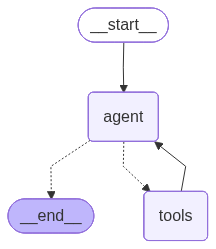

In [8]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
def run_agent(user_input: str, thread_id: str = "1"):
    config = {"configurable": {"thread_id": thread_id}}

    print(f"\n🤖 Question: {user_input}\n")

    for event in app.stream(
        {"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"
    ):
        event["messages"][-1].pretty_print()

In [10]:
# Example 1: Weather
run_agent("What is the weather in Paris?")


🤖 Question: What is the weather in Paris?

================================ Human Message =================================

What is the weather in Paris?


================================== Ai Message ==================================
Tool Calls:
  get_weather (4af8adf0-262c-42b8-bcc1-23c3f6d7b515)
 Call ID: 4af8adf0-262c-42b8-bcc1-23c3f6d7b515
  Args:
    city: Paris
================================= Tool Message =================================
Name: get_weather

Weather in Paris:
        - Temperature: 10°C
        - Conditions: Light rain shower
        - Humidity: 76%
        - Wind: 18 km/h
================================== Ai Message ==================================

The current weather in Paris is as follows:
- Temperature: 10°C
- Conditions: Light rain shower
- Humidity: 76%
- Wind: 18 km/h


In [11]:
# Example 2: Internet search
run_agent("Who invented Python (the programming language)?")


🤖 Question: Who invented Python (the programming language)?

================================ Human Message =================================

Who invented Python (the programming language)?
================================== Ai Message ==================================
Tool Calls:
  search_internet (25a4cf31-92ee-4a9f-9e8e-5d3d9ca5a9d9)
 Call ID: 25a4cf31-92ee-4a9f-9e8e-5d3d9ca5a9d9
  Args:
    query: who invented Python programming language
================================= Tool Message =================================
Name: search_internet

No information available
================================== Ai Message ==================================

The Python programming language was invented by Guido van Rossum. He began development in the late 1980s and released the first public version in 1991.


In [12]:
# Example 3: Combination
run_agent("What time is it and what is the weather in Tokyo?")


🤖 Question: What time is it and what is the weather in Tokyo?

================================ Human Message =================================

What time is it and what is the weather in Tokyo?
================================== Ai Message ==================================
Tool Calls:
  get_current_time (050eb927-debf-4a02-9a86-b988bdb9b96b)
 Call ID: 050eb927-debf-4a02-9a86-b988bdb9b96b
  Args:
  get_weather (8b8cbca0-2cad-4080-bf2d-80de048c50fe)
 Call ID: 8b8cbca0-2cad-4080-bf2d-80de048c50fe
  Args:
    city: Tokyo
================================= Tool Message =================================
Name: get_weather

Weather in Tokyo:
        - Temperature: 10°C
        - Conditions: Clear
        - Humidity: 58%
        - Wind: 26 km/h
================================== Ai Message ==================================

The current time is 03/02/2026 at 19:32:27. The weather in Tokyo is as follows:
- Temperature: 10°C
- Conditions: Clear
- Humidity: 58%
- Wind: 26 km/h


In [13]:
# Example 4: Conversion
run_agent("Convert 1000 euros to US dollars")


🤖 Question: Convert 1000 euros to US dollars

================================ Human Message =================================

Convert 1000 euros to US dollars
================================== Ai Message ==================================
Tool Calls:
  convert_currency (21d20548-89af-4930-b456-95013d31c064)
 Call ID: 21d20548-89af-4930-b456-95013d31c064
  Args:
    to_currency: USD
    amount: 1000
    from_currency: EUR
================================= Tool Message =================================
Name: convert_currency

1000.0 EUR = 1180.00 USD
================================== Ai Message ==================================

1000 euros is approximately 1180 US dollars.


In [14]:
# Example 6: Calculation
run_agent("Calculate the square root of 144 plus 10% of 500")


🤖 Question: Calculate the square root of 144 plus 10% of 500

================================ Human Message =================================

Calculate the square root of 144 plus 10% of 500
================================== Ai Message ==================================
Tool Calls:
  python_repl_ast (f1acd419-788d-4975-8eed-1c1b3ee63eba)
 Call ID: f1acd419-788d-4975-8eed-1c1b3ee63eba
  Args:
    query: import math; math.sqrt(144) + 0.1 * 500
================================= Tool Message =================================
Name: python_repl_ast

62.0
================================== Ai Message ==================================

The square root of 144 plus 10% of 500 is 62.0.


In [ ]:
# Example 6: Calculation
run_agent("what is the latest version of prefect? Check on PYPI")


🤖 Question: what is the latest version of prefect? Check on PYPI

================================ Human Message =================================

what is the latest version of prefect? Check on PYPI
================================== Ai Message ==================================
Tool Calls:
  search_internet (d8081d8c-f50e-4c8c-9089-ee5550130c8a)
 Call ID: d8081d8c-f50e-4c8c-9089-ee5550130c8a
  Args:
    query: latest version of prefect on PyPI
================================= Tool Message =================================
Name: search_internet

No information available
================================== Ai Message ==================================

I couldn't find the latest version of Prefect directly from PyPI through this query. Let me try a more specific search.
Tool Calls:
  search_internet (447eaae9-ee24-4b42-8c85-56e17d8b5555)
 Call ID: 447eaae9-ee24-4b42-8c85-56e17d8b5555
  Args:
    query: latest version of prefect package on PyPI
================================= Tool M